In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from faces_clustering import Clusterer, is_image, get_files_folder

Using TensorFlow backend.


In [2]:
import random
random.seed(42)

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
backbones = ['resnet50','senet50','vgg16']

# DataSeparation

In [ ]:
df_embs = pd.read_pickle(f'../data/valid/raw/leg55_{backbones[0]}.pkl')

In [ ]:
test_index = df_embs.sample(frac=1, random_state=42).groupby('classes').head(1).sort_values('classes').index

In [ ]:
for backbone in backbones:
    df_backbone = pd.read_pickle(f'../data/valid/leg55_{backbone}.pkl')
    df_test = df_backbone.loc[test_index].copy()
    df_train = df_backbone.loc[df_embs.index.difference(test_index)].copy()
    
    df_train.to_pickle(f'../data/valid/train_leg55_{backbone}.pkl')
    df_test.to_pickle(f'../data/valid/test_leg55_{backbone}.pkl')

# Clustering Train

In [ ]:
all_clusters = {}
for backbone in backbones:
    df_train = pd.read_pickle(f'../data/valid/train_leg55_{backbone}.pkl')
    clusterer = Clusterer(n_clusters=513, face_embeddings = df_train,algs=[
        'kmeans', 'affinity', 'agglomerative'])
    clusters, models_inst = clusterer.clusterize(normalize=False)
    
    all_clusters[backbone] = clusters

In [ ]:
dt_clusters = pd.concat(all_clusters.values(), keys = all_clusters.keys())

In [ ]:
dt_clusters.to_pickle('../data/valid/clusters_train_leg55.pkl')

In [ ]:
dt_clusters = pd.read_pickle('../data/valid/clusters_train_leg55.pkl')

In [ ]:
print(f"Train Size: {dt_clusters.loc['resnet50'].shape[0]}")

## Evaluating Train

In [ ]:
from sklearn import metrics

In [ ]:
df_all = {}
for backbone in backbones:
    clusters = dt_clusters.loc[backbone]
    
    cluster_cols = [c for c in clusters.columns if str(c).startswith('cluster')]
    labels_true = clusters.classes.values
    
    dict_results = {}
    for col in cluster_cols:
        labels_pred = clusters[col].values

        dict_results[col] = [metrics.homogeneity_score(labels_true,labels_pred),
                            metrics.completeness_score(labels_true, labels_pred),
                            metrics.v_measure_score(labels_true, labels_pred)]
    df_all[backbone] = pd.DataFrame.from_dict(dict_results, orient='index', columns=[
        'Homogeneity Score', 'Completeness Score', 'V-Measure'])
    
df_all_results = pd.concat(df_all.values(), keys=df_all.keys())
    

In [ ]:
df_all_results

In [5]:
pd.read_csv('../results/valid/clusters.csv', index_col=[0,1])

Homogeneity Score  Completeness Score  \
resnet50 cluster_kmeans                   0.93590             0.94514   
         cluster_affinity                 0.95382             0.91757   
         cluster_agglomerative            0.94915             0.95839   
senet50  cluster_kmeans                   0.93804             0.94964   
         cluster_affinity                 0.95357             0.93814   
         cluster_agglomerative            0.95369             0.96076   
vgg16    cluster_kmeans                   0.80912             0.82289   
         cluster_affinity                 0.00000             1.00000   
         cluster_agglomerative            0.85415             0.86839   

                                V-Measure  
resnet50 cluster_kmeans           0.94049  
         cluster_affinity         0.93535  
         cluster_agglomerative    0.95375  
senet50  cluster_kmeans           0.94380  
         cluster_affinity         0.94580  
         cluster_agglomerative    0.95721  
vgg16    cluster_kmeans           0.81595  
         cluster_affinity         0.00000  
         cluster_agglomerative    0.86121

# Test

In [6]:
from faces_clustering import FaceSearcher
backbone = backbones[1]

In [7]:
df_embs = pd.read_pickle('../data/valid/distances/senet50_agglomerative.pkl')

In [8]:
df_embs.shape

(8105, 7)

In [9]:
searcher = FaceSearcher(face_embs = df_embs, classes_col = 'cluster_agglomerative', distance_col = 'd_cluster_agglomerative')

In [10]:
df_test = pd.read_pickle('../data/valid/test_leg55_senet50.pkl')

In [11]:
print(f"Test size is {df_test.shape[0]}")

Test size is 513


In [12]:
embs_query = [l.tolist() for l in df_test.embeddings.values]

In [13]:
_, results = searcher.closest_centroids(embs_query = embs_query)

In [15]:
softmax = lambda x: np.exp(x)/sum(np.exp(x))

In [151]:
def m1(x, k):
    m1 = softmax((1/x).nlargest(k)).head(1)
    return (m1.index.values[0],m1.values[0])

In [152]:
pcts = [m1(r,5)[1] for r in results]

In [153]:
np.mean(np.array(pcts)>=0.5)

0.935672514619883

In [154]:
np.mean(np.array(pcts))

0.8831789966953282

In [149]:
import matplotlib.pyplot as plt

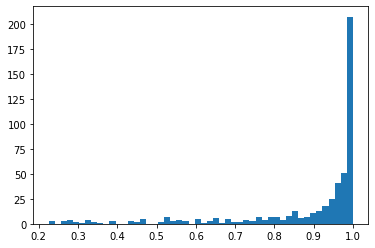

In [150]:
_ = plt.hist(pcts, bins=50)

In [119]:
df_test['results'] = results

In [122]:
mode_clusters = df_embs.groupby('cluster_agglomerative')['classes'].apply(lambda x: x.value_counts(dropna=False).idxmax())

In [158]:
classes_by_cluster = df_embs.groupby('cluster_agglomerative')['classes'].apply(set)

In [179]:
any_k = []
mode_k = []
has_class_k = []

for k in range(2,11):
    p_clusters = df_test['results'].apply(lambda x: m1(x,k)[0] if m1(x,k)[1] >= 0.5 else -1)
    any_k.append(np.mean(p_clusters != -1))
    #print(f"{k}: Assigned to any: {any_k[-1]}")
    mode_k.append((df_test.classes == p_clusters.map(mode_clusters)).mean())
    #print(f"{k}: Assigned to cluster of mode: {mode_k[-1]}")
    
    comp = []
    for myclass, classes in zip(df_test.classes,p_clusters.map(classes_by_cluster)):
        comp.append(classes == classes and myclass in classes)
    has_class_k.append(np.mean(comp))    
    #print(f"{k}: Assigned to cluster with class in the cluster {has_class_k[-1]}")

In [187]:
df_results = pd.DataFrame(np.transpose([any_k, mode_k, has_class_k]),
             index = range(2,11), columns=['Any_Cluster', 'Mode Equal to Class', 'Class is present in cluster'])
df_results

,Any_Cluster,Mode Equal to Class,Class is present in cluster
2,1.00000,0.91228,0.96101
3,0.95906,0.89864,0.93957
4,0.94932,0.89279,0.93177
5,0.93567,0.88109,0.91813
6,0.91228,0.86160,0.89474
7,0.89864,0.85185,0.88109
8,0.89474,0.84795,0.87719
9,0.89084,0.84405,0.87329
10,0.87329,0.83041,0.85575


## Checking wrong classes

In [204]:
p_clusters = df_test['results'].apply(lambda x: m1(x,2)[0] if m1(x,2)[1] >= 0.5 else -1)

In [214]:
classes_wrong = df_test.loc[df_test.classes != p_clusters.map(mode_clusters)].classes

In [260]:
classes_right = df_test.loc[df_test.classes == p_clusters.map(mode_clusters)].classes

In [272]:
classes_count = df_embs.groupby('classes')['urls'].count()

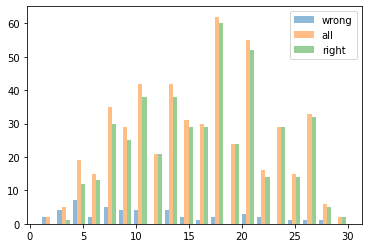

In [333]:
import matplotlib.pyplot as plt

_ = plt.hist([classes_wrong.map(classes_count), classes_count, classes_right.map(classes_count)], 
    density=False, bins=20, alpha=0.5, label=['wrong', 'all', 'right'])
_ = plt.legend()
#_ = plt.hist(, density=True, bins=12, alpha=0.5,label = 'class dist')

In [305]:
def fxs(x):
    if x < 6:
        return '1-5'
    if x < 11:
        return '6-10'
    if x < 16:
        return '11-15'
    if x < 21:
        return '16-20'
    if x < 26:
        return '21-25'
    return '26-30'

In [330]:
df_fxs_count = pd.concat([classes_wrong.map(classes_count).apply(fxs).value_counts(),
            classes_right.map(classes_count).apply(fxs).value_counts()], axis=1).reindex(
    ['1-5','6-10','11-15','16-20','21-25','26-30'])
df_fxs_count

,classes,classes
1-5,13,13
6-10,13,84
11-15,8,110
16-20,3,135
21-25,6,87
26-30,2,39


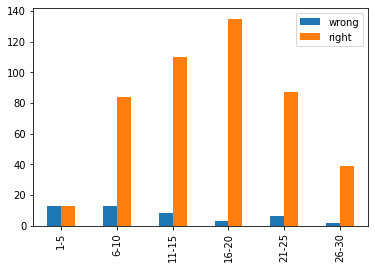

In [332]:
df_fxs_count.columns = ['wrong','right']
df_fxs_count.plot.bar()

# LFW

In [46]:
from faces_clustering import FeatureExtractor

In [47]:
path = '/home/paulo/Documentos/0_LFW_dataset'

In [48]:
lfw = get_files_folder(path, criteria=is_image)

In [49]:
sample = random.sample(lfw, 513)

In [50]:
df_lfw = FeatureExtractor('senet50').extract(sample)
df_lfw.head(3)

,urls,embeddings
0,/home/paulo/Documentos/0_LFW_dataset/Kim_Dae-j...,"[0.48840332, 0.144612, 0.0148019, 0.05020816, ..."
1,/home/paulo/Documentos/0_LFW_dataset/Hans_Blix...,"[1.6899444, 0.052105, 0.20930415, 0.47116968, ..."
2,/home/paulo/Documentos/0_LFW_dataset/Pete_Samp...,"[0.047221407, 1.1174889, 0.0030544905, 0.27338..."


In [51]:
lfw_query = [l.tolist() for l in df_lfw.embeddings.values]

In [52]:
_, results_lfw = searcher.closest_centroids(embs_query = lfw_query)

In [130]:
df_lfw['results'] = results_lfw

In [183]:
lfw = []
for k in range(2,11):
    lfw_clusters = df_lfw['results'].apply(lambda x: m1(x,k)[0] if m1(x,k)[1] >= 0.5 else -1)
    print(f"k: {k} {np.mean(lfw_clusters==-1)}")
    lfw.append(np.mean(lfw_clusters==-1))

k: 2 0.0
k: 3 0.9434697855750487
k: 4 0.9824561403508771
k: 5 0.9883040935672515
k: 6 0.9941520467836257
k: 7 0.9980506822612085
k: 8 0.9980506822612085
k: 9 0.9980506822612085
k: 10 0.9980506822612085


In [189]:
df_results.index.name='alpha'
df_results['lfw assigned to no cluster'] = lfw

,Any_Cluster,Mode Equal to Class,Class is present in cluster,lfw assigned to no cluster
alpha,,,,
2,1.00000,0.91228,0.96101,0.00000
3,0.95906,0.89864,0.93957,0.94347
4,0.94932,0.89279,0.93177,0.98246
5,0.93567,0.88109,0.91813,0.98830
6,0.91228,0.86160,0.89474,0.99415
7,0.89864,0.85185,0.88109,0.99805
8,0.89474,0.84795,0.87719,0.99805
9,0.89084,0.84405,0.87329,0.99805
10,0.87329,0.83041,0.85575,0.99805


In [203]:
df_results.apply(lambda x: x.apply(lambda y: f"{y*100:.4f} %"))

,Any_Cluster,Mode Equal to Class,Class is present in cluster,lfw assigned to no cluster
alpha,,,,
2,100.0000 %,91.2281 %,96.1014 %,0.0000 %
3,95.9064 %,89.8635 %,93.9571 %,94.3470 %
4,94.9318 %,89.2788 %,93.1774 %,98.2456 %
5,93.5673 %,88.1092 %,91.8129 %,98.8304 %
6,91.2281 %,86.1598 %,89.4737 %,99.4152 %
7,89.8635 %,85.1852 %,88.1092 %,99.8051 %
8,89.4737 %,84.7953 %,87.7193 %,99.8051 %
9,89.0838 %,84.4055 %,87.3294 %,99.8051 %
10,87.3294 %,83.0409 %,85.5750 %,99.8051 %
